In [131]:
%pip install rasterio

Note: you may need to restart the kernel to use updated packages.


In [132]:
%pip install rasterstats

Note: you may need to restart the kernel to use updated packages.


#  3.1 Preparación de datos
1. Cargue formas de límites y asegúrese de que los campos de nombre/UBIGEO estén en mayúsculas y sin diacríticos.

In [133]:
print("CWD:", os.getcwd())

CWD: d:\MIS DOCUMENTOS\Documents\GitHub\Raster_Analysis_Public_Policy_Streamlit\notebook


In [134]:
import geopandas as gpd
import rasterio
from rasterio.mask import mask
from rasterstats import zonal_stats

# Cargar shapefile
shapefile_path = os.path.join("..", "data", "shape_file", "DISTRITOS.shp")
gdf = gpd.read_file(shapefile_path)

gdf.head()

,IDDPTO,DEPARTAMEN,IDPROV,PROVINCIA,IDDIST,DISTRITO,CAPITAL,CODCCPP,AREA,FUENTE,geometry
0,10,HUANUCO,1009,PUERTO INCA,100902,CODO DEL POZUZO,CODO DEL POZUZO,0001,1,INEI,"POLYGON ((-75.31797 -9.29529, -75.3171 -9.2975..."
1,10,HUANUCO,1009,PUERTO INCA,100904,TOURNAVISTA,TOURNAVISTA,0001,1,INEI,"POLYGON ((-74.64136 -8.82302, -74.64036 -8.828..."
2,25,UCAYALI,2503,PADRE ABAD,250305,ALEXANDER VON HUMBOLDT,ALEXANDER VON HUMBOLDT,0001,1,INEI,"POLYGON ((-75.02253 -8.74193, -75.02267 -8.742..."
3,25,UCAYALI,2503,PADRE ABAD,250302,IRAZOLA,SAN ALEJANDRO,0001,1,INEI,"POLYGON ((-75.13864 -8.56712, -75.13956 -8.569..."
4,25,UCAYALI,2503,PADRE ABAD,250304,NESHUYA,MONTE ALEGRE,0001,1,INEI,"POLYGON ((-75.01589 -8.44637, -75.01585 -8.446..."


2. Cargar el GeoTIFF Tmin . Si es multibanda (meses/años), iterar sobre las bandas (suponiendo que Banda 1 = 2020, etc.).

In [ ]:
import rasterio

# Ruta al archivo
archivo = os.path.join("..", "data", "tmin_raster.tif")
#archivo = "tmin_raster.tif"

# Abrir el archivo
with rasterio.open(archivo) as src:
    print("Ancho:", src.width)
    print("Alto:", src.height)
    print("Número de bandas:", src.count)
    print("Sistema de coordenadas:", src.crs)
    print("Transformación (afín):", src.transform)

    # Leer los datos de la primera banda
    banda1 = src.read(1)
    banda2 = src.read(2)
    banda3 = src.read(3)
    banda4 = src.read(4)
    banda5 = src.read(5)


Ancho: 285
Alto: 397
Número de bandas: 5
Sistema de coordenadas: EPSG:4326
Transformación (afín): | 0.05, 0.00,-81.38|
| 0.00,-0.05, 1.20|
| 0.00, 0.00, 1.00|


- *Ancho: 285 píxeles**  
  Esto indica que el raster tiene 2853 columnas, es decir, 2853 celdas horizontales.

- *Alto: 397 píxeles**  
  Significa que tiene 397 filas, es decir, 397 celdas verticales.

- *Número de bandas: 5**  
  Cada banda puede representar una dimensión distinta del mismo fenómeno.

- *Sistema de coordenadas: EPSG:4326**

- *Transformación afín:**  
  Esto nos permite traducir las coordenadas de píxeles a coordenadas geográficas reales:

  - El valor `-81.38` indica la **longitud del borde izquierdo** del raster.
  - El valor `1.20` indica la **latitud del borde superior**.
  - El valor `0.05` nos dice que cada píxel equivale a **0.05 grados de longitud**.
  - El valor `-0.05` nos dice que cada fila de píxeles desciende en **0.05 grados de latitud**  
    (por eso es negativo: el raster se "construye" de arriba hacia abajo).


# 3.2 Estadísticas zonales
* UNIDADES: Con el siguiente código confirmamos que el raster no necesita resscalamiento:

In [136]:
import os, numpy as np, rasterio as rio

archivo = os.path.join("..","data","tmin_raster.tif")

with rio.open(archivo) as src:
    print("dtype:", src.dtypes)             # p.ej. int16 suele venir escalado
    print("bands:", src.count)
    print("scales:", getattr(src, "scales", None))   # a veces trae [0.1]
    print("offsets:", getattr(src, "offsets", None)) # a veces trae [0.0]
    print("tags:", src.tags(1))                      # busca 'scale_factor', 'add_offset', 'units', etc.

    a = src.read(1, masked=True)  # lee como masked array (respeta nodata)
    print("min/max (raw):", float(a.min()), float(a.max()))


dtype: ('float32', 'float32', 'float32', 'float32', 'float32')
bands: 5
scales: (1.0, 1.0, 1.0, 1.0, 1.0)
offsets: (0.0, 0.0, 0.0, 0.0, 0.0)
tags: {}
min/max (raw): nan nan


promedio de temperaturas minimas en cada distrito 

In [137]:
# Calcular estadísticas zonales por banda
promedios = []
for b in range(1, 6):
    stats = zonal_stats(gdf, archivo, stats=["mean"], band=b)
    promedios.append([s["mean"] for s in stats])

# Crear columnas para cada banda en el GeoDataFrame
for i, valores in enumerate(promedios):
    gdf[f"tmin_banda{i+1}"] = valores

# Calcular el promedio total de las 5 bandas
gdf["tmin_promedio_total"] = gdf[[f"tmin_banda{i+1}" for i in range(5)]].mean(axis=1)

# Mostrar resultados con los nombres de distritos
print(gdf[["DISTRITO", "tmin_promedio_total"]].head())

                 DISTRITO  tmin_promedio_total
0         CODO DEL POZUZO            18.761000
1             TOURNAVISTA            22.048223
2  ALEXANDER VON HUMBOLDT            21.862907
3                 IRAZOLA            22.097315
4                 NESHUYA            21.937903


* Merge con la data de distritos de Perú

In [140]:
# Reproyectar shapefile si es necesario (para que coincida con el raster)

#archivo = os.path.join("..", "data", "tmin_raster.tif")
with rasterio.open(archivo) as src:
    if gdf.crs != src.crs:
        gdf = gdf.to_crs(src.crs)

    # Recortar el raster usando el shapefile
    out_image, out_transform = mask(src, gdf.geometry, crop=True)
    out_meta = src.meta.copy()

# Actualizar metadata para el nuevo raster recortado
out_meta.update({
    "height": out_image.shape[1],
    "width": out_image.shape[2],
    "transform": out_transform
})

# Guardar el nuevo raster recortado (opcional)
with rasterio.open("recorte.tif", "w", **out_meta) as dest:
    dest.write(out_image)

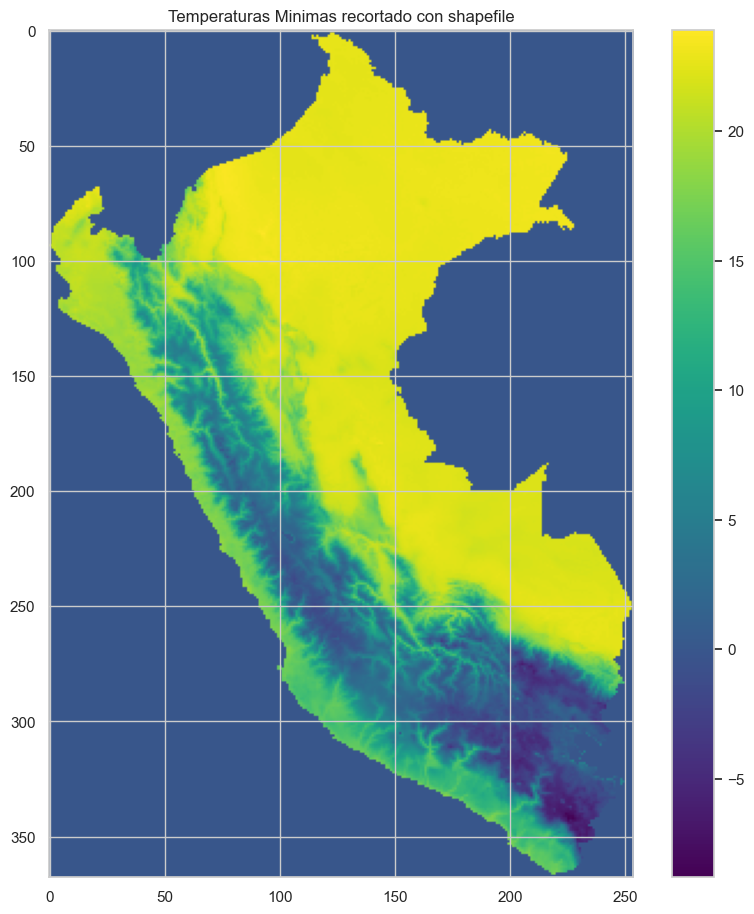

In [141]:
# Ploteamos el mapa de tempertura minima del Perú
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 11))
plt.imshow(out_image[0], cmap='viridis')
plt.title("Temperaturas Minimas recortado con shapefile")
plt.colorbar()
plt.show()


Recorte del ráster completo (las 5 bandas) a Perú usando los distritos

In [142]:
from rasterio.mask import mask

# Abrir y recortar todas las bandas del ráster
with rasterio.open(archivo) as src:
    out_image, out_transform = mask(src, gdf.geometry, crop=True)
    out_meta = src.meta.copy()

out_meta.update({
    "driver": "GTiff",
    "height": out_image.shape[1],
    "width": out_image.shape[2],
    "transform": out_transform
})

# Guardar el nuevo ráster recortado
with rasterio.open("tmin_peru_recortado.tif", "w", **out_meta) as dest:
    dest.write(out_image)

MÉTRICAS MÍNIMAS: count , mean, min, max, std, percentile_10, percentile_90(+1 personalizado).

In [160]:

# Crear una columna de departamento para análisis si no existe
if 'DEPARTAMENTO' not in gdf.columns:
    if 'DEPARTAME' in gdf.columns:
        gdf['DEPARTAMENTO'] = gdf['DEPARTAME']
    elif 'IDDPTO' in gdf.columns:
        # Mapeo completo de códigos de departamento a nombres en Perú
        dpto_map = {
            '01': 'AMAZONAS',
            '02': 'ANCASH',
            '03': 'APURIMAC',
            '04': 'AREQUIPA',
            '05': 'AYACUCHO',
            '06': 'CAJAMARCA',
            '07': 'CALLAO',
            '08': 'CUSCO',
            '09': 'HUANCAVELICA',
            '10': 'HUANUCO',
            '11': 'ICA',
            '12': 'JUNIN',
            '13': 'LA LIBERTAD',
            '14': 'LAMBAYEQUE',
            '15': 'LIMA',
            '16': 'LORETO',
            '17': 'MADRE DE DIOS',
            '18': 'MOQUEGUA',
            '19': 'PASCO',
            '20': 'PIURA',
            '21': 'PUNO',
            '22': 'SAN MARTIN',
            '23': 'TACNA',
            '24': 'TUMBES',
            '25': 'UCAYALI'
        }
        # Aplicar el mapeo, asegurando que siempre hay un nombre de departamento
        gdf['DEPARTAMENTO'] = gdf['IDDPTO'].astype(str).map(lambda x: dpto_map.get(x, f"DPTO_{x}"))

# 1. Análisis Estadístico Básico
print("Estadísticas descriptivas de temperatura promedio:")
stats = gdf['tmin_promedio_total'].describe()
stats.head()


Estadísticas descriptivas de temperatura promedio:


count    1789.000000
mean        9.453099
std         6.878138
min        -5.191071
25%         3.943483
Name: tmin_promedio_total, dtype: float64

NIVEL TERRITORIAL: distrito (preferible); utilice provincia/departamento si está limitado por el hardware.


Columnas disponibles en el dataframe:
['IDDPTO', 'DEPARTAMEN', 'IDPROV', 'PROVINCIA', 'IDDIST', 'DISTRITO', 'CAPITAL', 'CODCCPP', 'AREA', 'FUENTE', 'geometry', 'tmin_banda1', 'tmin_banda2', 'tmin_banda3', 'tmin_banda4', 'tmin_banda5', 'tmin_promedio_total', 'DEPARTAMENTO']


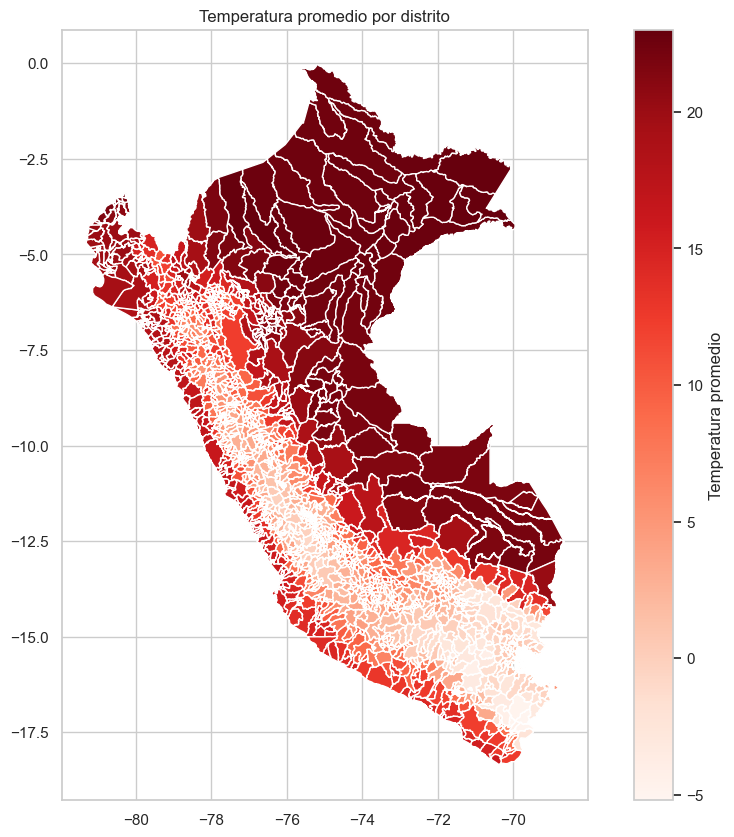

In [145]:
# Visualizar los resultados en un mapa
fig, ax = plt.subplots(1, 1, figsize=(12, 10))
gdf.plot(column="tmin_promedio_total", 
         ax=ax, 
         legend=True, 
         cmap="Reds", 
         legend_kwds={'label': "Temperatura promedio"})
ax.set_title("Temperatura promedio por distrito")

# Primero, verifiquemos los nombres exactos de las columnas
print("\nColumnas disponibles en el dataframe:")
print(gdf.columns.tolist())

# 3.3 Análisis y visualizaciones
Distribución: histograma/KDE de la media Tmin a nivel de distrito .

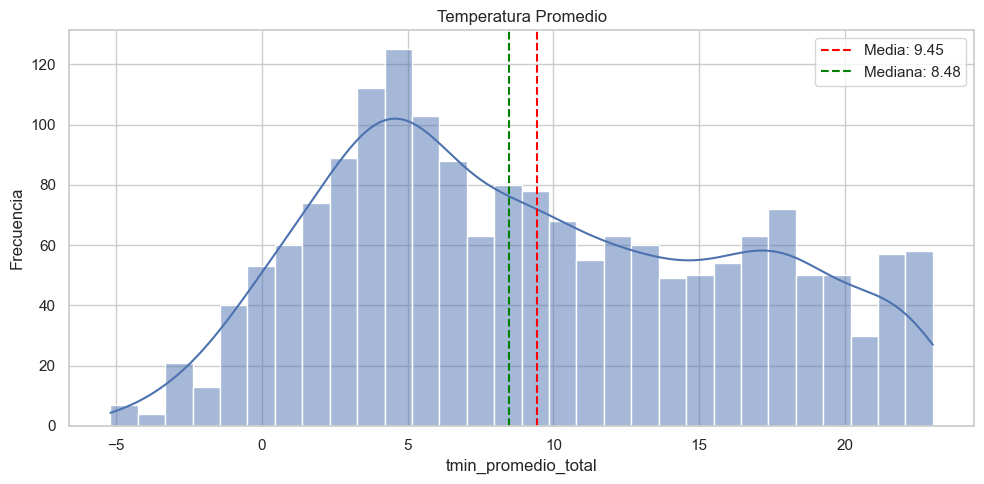

In [147]:
# 2. Histograma de Temperatura Promedio
plt.figure(figsize=(10, 5))
sns.histplot(gdf['tmin_promedio_total'], kde=True, bins=30)
plt.title('Temperatura Promedio')
plt.ylabel('Frecuencia')
plt.axvline(gdf['tmin_promedio_total'].mean(), color='red', linestyle='--', 
            label=f'Media: {gdf["tmin_promedio_total"].mean():.2f}')
plt.axvline(gdf['tmin_promedio_total'].median(), color='green', linestyle='--', 
            label=f'Mediana: {gdf["tmin_promedio_total"].median():.2f}')
plt.legend()
plt.tight_layout()
plt.savefig('histograma_temperatura.png', dpi=300)
plt.show()

CLASIFICACIÓN: Top 15 distritos con menor temperatura minima (15 distritos principales con Tmin medio más bajo (riesgo de heladas))

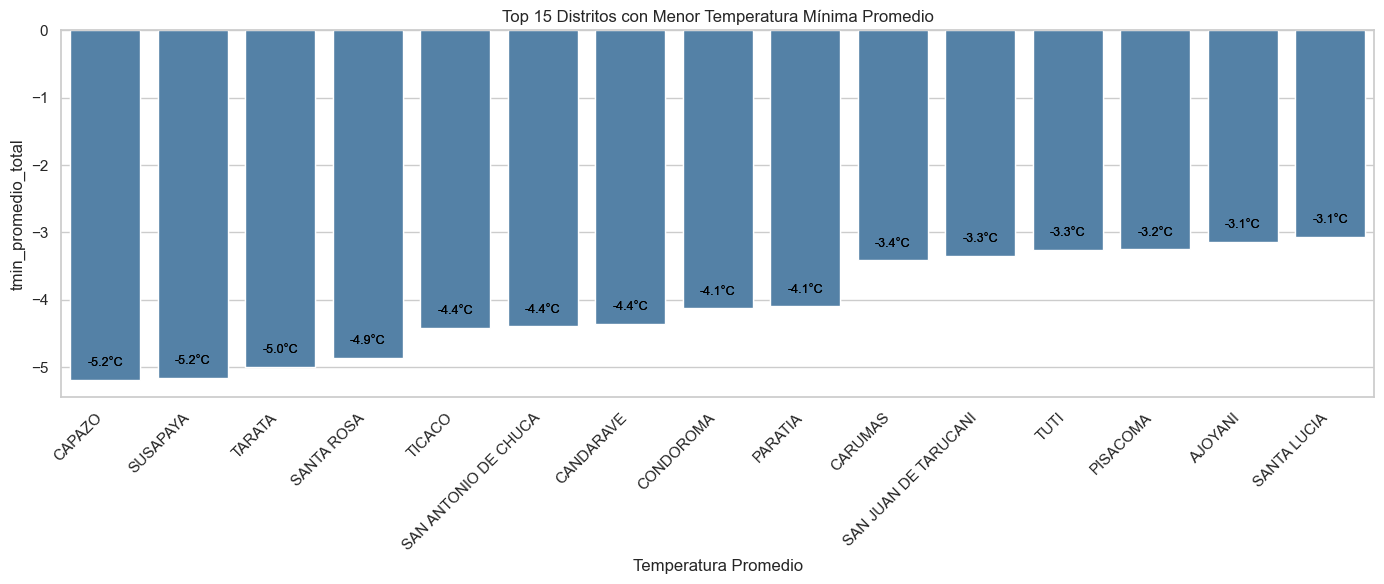

In [148]:
top15 = gdf.sort_values(by='tmin_promedio_total').head(15)
plt.figure(figsize=(14, 6))
sns.barplot(x='DISTRITO', y='tmin_promedio_total', data=top15)
plt.title('Top 15 Distritos con Menor Temperatura Mínima Promedio')
plt.xticks(rotation=45, ha='right')
plt.xlabel('Temperatura Promedio')
ax = sns.barplot(x='DISTRITO', y='tmin_promedio_total', data=top15, color='steelblue')
for p in ax.patches:
    ax.text(
        p.get_x() + p.get_width() / 2,   # posición horizontal centrada
        p.get_height() + 0.2,            # posición vertical un poco encima
        f"{p.get_height():.1f}°C",       # valor con un decimal
        ha='center', fontsize=9, color='black'
    )
plt.tight_layout()
plt.savefig('top15_distritos_menor_temperatura.png', dpi=300)
plt.show()

CLASIFICACIÓN 4. Top 15 distritos con mayor temperatura: 15 distritos principales con Tmin medio más alto .

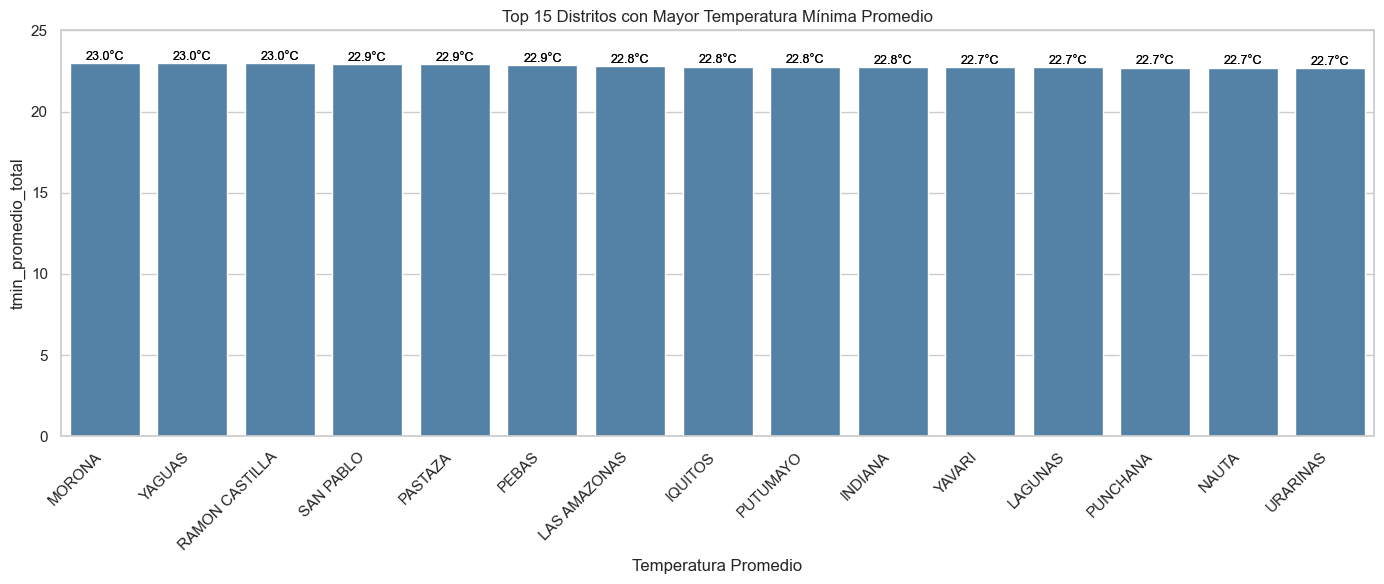

In [149]:
top15 = gdf.sort_values(by='tmin_promedio_total', ascending=False).head(15)
plt.figure(figsize=(14, 6))
sns.barplot(x='DISTRITO', y='tmin_promedio_total', data=top15)
plt.title('Top 15 Distritos con Mayor Temperatura Mínima Promedio')
plt.xticks(rotation=45, ha='right')
plt.xlabel('Temperatura Promedio')
plt.ylim(0, 25) 
ax = sns.barplot(x='DISTRITO', y='tmin_promedio_total', data=top15, color='steelblue')
for p in ax.patches:
    ax.text(
        p.get_x() + p.get_width() / 2,   # posición horizontal centrada
        p.get_height() + 0.2,            # posición vertical un poco encima
        f"{p.get_height():.1f}°C",       # valor con un decimal
        ha='center', fontsize=9, color='black'
    )
plt.tight_layout()
plt.savefig('top15_distritos_mayor_temperatura.png', dpi=300)

plt.show()

MAPA: coropleta estática con GeoPandas; guarde PNG para la aplicación y proporcione una tabla descargable .

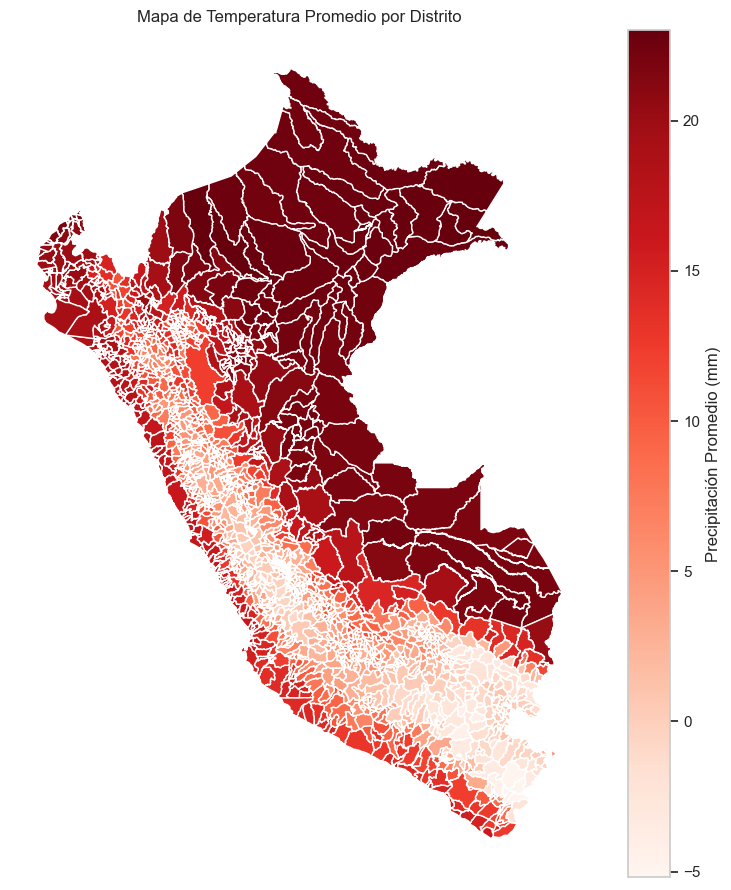

In [150]:
fig, ax = plt.subplots(1, 1, figsize=(10, 11))
gdf.plot(column='tmin_promedio_total', cmap='Reds', legend=True, 
         legend_kwds={'label': "Precipitación Promedio (mm)"},
         ax=ax)
ax.set_title('Mapa de Temperatura Promedio por Distrito')
ax.set_axis_off()
plt.savefig('mapa_temperatura.png', dpi=300, bbox_inches='tight')
plt.show()

MAPA: proporcioonas una tabla descargable

* Tabla resumen por distritos

In [151]:
# Seleccionar columnas relevantes
tabla_distrital = gdf[['IDDIST', 'DEPARTAMENTO', 'PROVINCIA', 'DISTRITO', 
                       'tmin_promedio_total']].copy()

# Redondear la temperatura a 2 decimales
tabla_distrital['tmin_promedio_total'] = tabla_distrital['tmin_promedio_total'].round(2)

# Guardar en CSV
tabla_distrital.to_csv('tabla_tmin_distrital.csv', index=False, encoding='utf-8-sig')

print("Tabla resumen distrital guardada como 'tabla_tmin_distrital.csv'")
tabla_distrital.head()


Tabla resumen distrital guardada como 'tabla_tmin_distrital.csv'


,IDDIST,DEPARTAMENTO,PROVINCIA,DISTRITO,tmin_promedio_total
0,100902,HUANUCO,PUERTO INCA,CODO DEL POZUZO,18.76
1,100904,HUANUCO,PUERTO INCA,TOURNAVISTA,22.05
2,250305,UCAYALI,PADRE ABAD,ALEXANDER VON HUMBOLDT,21.86
3,250302,UCAYALI,PADRE ABAD,IRAZOLA,22.10
4,250304,UCAYALI,PADRE ABAD,NESHUYA,21.94


* Tabla resumen por regiones

In [152]:
# Agrupar por departamento y calcular estadísticas básicas
tabla_departamental = (
    gdf.groupby('DEPARTAMENTO')['tmin_promedio_total']
       .agg(['count', 'mean', 'min', 'max', 'std'])
       .reset_index()
)

# Redondear
tabla_departamental = tabla_departamental.round(2)

# Guardar CSV
tabla_departamental.to_csv('tabla_tmin_departamental.csv', index=False, encoding='utf-8-sig')

print("Tabla resumen departamental guardada como 'tabla_tmin_departamental.csv'")
tabla_departamental.head()


Tabla resumen departamental guardada como 'tabla_tmin_departamental.csv'


,DEPARTAMENTO,count,mean,min,max,std
0,AMAZONAS,80,13.07,7.72,21.69,3.33
1,ANCASH,162,7.70,1.53,17.70,3.92
2,APURIMAC,83,5.41,0.56,11.73,2.67
3,AREQUIPA,102,6.83,-4.39,17.38,6.01
4,AYACUCHO,117,6.25,0.93,17.38,2.82


# 3. 4 Medidas de Polìtica

Paso 1. Identificar zonas críticas

Filtra los distritos con Tmin ≤ percentil 10 (p10), que representan las zonas de mayor riesgo.

In [153]:
# Calcular el percentil 10 de Tmin
p10 = gdf['tmin_promedio_total'].quantile(0.10)

# Filtrar distritos críticos
zonas_criticas = gdf[gdf['tmin_promedio_total'] <= p10]
zonas_criticas[['DEPARTAMENTO', 'PROVINCIA', 'DISTRITO', 'tmin_promedio_total']].head()


,DEPARTAMENTO,PROVINCIA,DISTRITO,tmin_promedio_total
39,TACNA,TARATA,TARUCACHI,0.728634
43,TACNA,TACNA,PALCA,-2.303472
49,TACNA,TARATA,TARATA,-4.995736
51,TACNA,TARATA,TICACO,-4.417395
55,TACNA,CANDARAVE,CAIRANI,-0.251786


In [154]:
# Conteo de distritos por departamento
zonas_criticas.groupby('DEPARTAMENTO')['DISTRITO'].count()


DEPARTAMENTO
APURIMAC         2
AREQUIPA        26
AYACUCHO         1
CUSCO           21
HUANCAVELICA    11
JUNIN           11
LIMA            15
MOQUEGUA         7
PASCO            1
PUNO            76
TACNA            8
Name: DISTRITO, dtype: int64

In [155]:
import numpy as np

# Listas de departamentos según tipo de fenómeno
heladas_altoandinas = [
    'PUNO', 'CUSCO', 'AYACUCHO', 'HUANCAVELICA',
    'PASCO', 'APURIMAC', 'JUNIN', 'AREQUIPA' ]

# Crear una nueva columna "REGION_FRIO" según el departamento
gdf['REGION_FRIO'] = np.select(
    [gdf['DEPARTAMENTO'].isin(heladas_altoandinas)],   # ← lista de condiciones
    ['HELADAS ALTOANDINAS'],                           # ← lista de resultados
    default='OTRAS REGIONES'                           # ← valor por defecto
)

# Verificar conteo por tipo de región
print(gdf['REGION_FRIO'].value_counts())

# Verificar algunos ejemplos
gdf[['DEPARTAMENTO', 'DISTRITO', 'tmin_promedio_total', 'REGION_FRIO']].head(10)


REGION_FRIO
OTRAS REGIONES         1087
HELADAS ALTOANDINAS     786
Name: count, dtype: int64


,DEPARTAMENTO,DISTRITO,tmin_promedio_total,REGION_FRIO
0,HUANUCO,CODO DEL POZUZO,18.761000,OTRAS REGIONES
1,HUANUCO,TOURNAVISTA,22.048223,OTRAS REGIONES
2,UCAYALI,ALEXANDER VON HUMBOLDT,21.862907,OTRAS REGIONES
3,UCAYALI,IRAZOLA,22.097315,OTRAS REGIONES
4,UCAYALI,NESHUYA,21.937903,OTRAS REGIONES
5,UCAYALI,PADRE ABAD,20.078721,OTRAS REGIONES
6,UCAYALI,CURIMANA,22.027528,OTRAS REGIONES
7,HUANUCO,PUERTO INCA,21.585726,OTRAS REGIONES
8,UCAYALI,NUEVA REQUENA,22.053295,OTRAS REGIONES
9,UCAYALI,CAMPOVERDE,21.911208,OTRAS REGIONES


In [156]:
# Distritos altoandinos
gdf_heladas = gdf[gdf['REGION_FRIO'] == 'HELADAS ALTOANDINAS']


In [157]:
gdf_heladas.to_file("distritos_heladas.geojson", driver='GeoJSON')



* Tabla resumen de la política a implementar 
Prevención de daños en la salud (IRA) en niños menores a 5 años provocados por las Heladas en las regiones Altoandinas

In [158]:
import pandas as pd

politicas = pd.DataFrame({
    'Región': ['Altiplano (heladas)'],
    'Objetivo específico': [
        'Reducir IRAs por heladas en zonas altoandinas',
        
    ],
    'Población': [
        'Distritos con Tmin ≤ p10 situados en regiones: Puno, Cusco, Ayacucho, Huancavelica, Pasco.',
        
    ],
    'Intervención': [
        'Kits de abrigo internado, kits de abrigo para población vulnerable (niñas y niños de cero meses hasta 5 años), vacunas contra la influenza',
       
    ],
    'Costo estimado (S/)': ['La intervención busca beneficiar a 219 691 niños menores de cinco años en las regiones priorizadas de Puno, Cusco, Ayacucho, Huancavelica y Pasco. De acuerdo con el Plan Multisectorial ante Heladas y Friajes 2022–2024, para las tres intervenciones propuestas se destinará un presupuesto total de S/ 5 056 527, equivalente a aproximadamente S/ 23 por niño beneficiario.'],
    'KPI': [
        'Evitar que el 80% de la población menor a 5 años se enferme por casos de IRA (Infección respiratoria aguda).',
        
    ]
})

politicas.to_csv('politicas_publicas_tmin.csv', index=False, encoding='utf-8-sig')
politicas


,Región,Objetivo específico,Población,Intervención,Costo estimado (S/),KPI
0,Altiplano (heladas),Reducir IRAs por heladas en zonas altoandinas,Distritos con Tmin ≤ p10 situados en regiones:...,"Kits de abrigo internado, kits de abrigo para ...",La intervención busca beneficiar a 219 691 niñ...,Evitar que el 80% de la población menor a 5 añ...
